In [23]:
from IPython.core.display import HTML
def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

In [24]:
import glob
s_dict = {'table_start': 0, 'hand_start': 1, 'off_start': 2}
fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
fu_dict = {'zero': 0, 'fifty': 1, 'ninety': 2}
b_dict = {'regular': 0, 'textured': 1}
l_dict = {'light0': 0, 'light1': 1}
c_dict = {'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4}
obj_id_dict = {1: 'red cup', 2: 'small white cup',3:'small transparent cup',4:'green glass',5:'wine glass',
              6:'champagne flute glass', 7:'cereal box',8:'biscuit box',9:'tea box', 10: 'sth', 11: 'sth2', 12: 'sth3'} 

valid_dict = {'s': list(s_dict.keys()), 
              'fi': list(fi_dict.keys()),
              'fu': list(fu_dict.keys()),
              'b': list(b_dict.keys()),
              'l': list(l_dict.keys()),
              'c': list(c_dict.keys()),
              'obj_id': list(obj_id_dict.keys()),
             }

def retrieve_data(obj_id, s, fi, fu, b, l, c=[]):
    if ((fi == 'nothing' and (fu =='fifty' or fu =='ninety')) or (fi == 'pasta' and fu == 'zero') or (fi == 'rice' and fu=='zero') or (fi=='water' and fu=='zero')): 
        #print('error')
        return -1
    for i in range(1,len(c),1):
        if c[i] not in valid_dict['c']:
            return -1
    if  (obj_id not in obj_id_dict) or (s not in valid_dict['s']) or (fi not in valid_dict['fi']) or (fu not in valid_dict['fu']) or (b not in valid_dict['b']) or (l not in valid_dict['l']) :
        return -1
    
    _obj_id = obj_id
    _s_id = s_dict[s]
    _fi_id = fi_dict[fi]
    _fu_id = fu_dict[fu]
    _b_id = b_dict[b]
    _l_id = l_dict[l]
    _c_id = []
    
    for i in range(0,len(c),1):
        _c_id.append(c_dict[c[i]])
    if(len(c)==0):
        _c_id = [1,2,3,4]
        
    input_string = 's'+str(_s_id)+'_fi'+str(_fi_id)+'_fu'+str(_fu_id)+'_b'+str(_b_id)+'_l'+str(_l_id)
    
    audio_path = "./*Dataset/"+str(_obj_id)+"/audio/"+input_string+"*"
    audio_list = glob.glob(audio_path)[0]
    
    calib_list = []
    for i in range(0,len(_c_id),1):
        calib_path = "./*Dataset/"+str(_obj_id)+"/calib/"+input_string+'_c'+str(_c_id[i])+'*'
        calib_list.append(glob.glob(calib_path)[0])
    
    depth_list = []
    for i in range(0,len(_c_id),1):
        depth_path = "./*Dataset/"+str(_obj_id)+"/depth/"+input_string+'/c'+str(_c_id[i])+'/*'
        depth_list.append(glob.glob(depth_path))
        
    imu_path = "./*Dataset/"+str(_obj_id)+"/imu/"+input_string+"*"
    imu_list = tuple(glob.glob(imu_path))
    
    
    ir_list=[]
    for i in range(0,len(_c_id),1):
        ir_path = "./*Dataset/"+str(_obj_id)+"/ir/"+input_string+'_c'+str(_c_id[i])+'*'
        ir_list.append(glob.glob(ir_path))
    
    
    rgb_list = []
    for i in range(0,len(_c_id),1):
        rgb_path = "./*Dataset/"+str(_obj_id)+"/rgb/"+input_string+'_c'+str(_c_id[i])+'*'
        rgb_list.append(glob.glob(rgb_path)[0])
    
    
    output_dict = {'audio': audio_list,'calib':calib_list,'depth':depth_list,'imu':imu_list,'ir':ir_list,'rgb':rgb_list}
    return output_dict

In [25]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torch.nn as nn

N_MFCC = 40

def load_and_extract_mfcc(path, window_size=20.0/1000, max_length=30):
    # Load audio data from file
    audio, sample_rate = librosa.load(path, res_type='kaiser_fast')
    
    length = audio.shape[0]
    step_size = int(window_size * sample_rate) # In samples    
    
    # Retrieve the sequence of MFCCs
    sequence = librosa.feature.mfcc(y=audio[:max_length*sample_rate], sr=sample_rate, n_mfcc=N_MFCC,
                                    hop_length=step_size)
    sequence = np.transpose(sequence)
    
    # Normalize the sequence according to its own data
    ### Normalization for each MFCC individually
    _mean = np.mean(sequence, axis=0)
    _std = np.std(sequence, axis=0)
    
    return (sequence - _mean) / _std

aux_dict = {'nothing': np.array([1., 0., 0., 0.]),
            'pasta': np.array([0., 1., 0., 0.]),
            'rice': np.array([0., 0., 1., 0.]),
            'water': np.array([0., 0., 0., 1.])}
data = []
labels = []
#LONGEST_SEQUENCE = 0
for obj_id in range(1, 10):
    print(f"Extracting data from object id: `{obj_id}`")
    for sit in s_dict.keys():
        for fi in fi_dict.keys():
            for fu in fu_dict.keys():
                for b in b_dict.keys():
                    for l in l_dict.keys():
                        try:
                            sample = retrieve_data(obj_id, s=sit, fi=fi, fu=fu, b=b, l=l)
                        except Exception as e:
                            print(f"Failed...: {(obj_id, sit, fi, fu, b, l)}")
                        if sample != -1:
                            seq_data = load_and_extract_mfcc(sample['audio'])
                            data.append(torch.Tensor(seq_data))
                            labels.append(fi_dict[fi])

data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=0)
#labels = torch.LongTensor(labels)
N_SAMPLES = len(data)
print(f"Got {N_SAMPLES} samples in total.")
print(len(data), len(labels))
print(data.shape)
SEQUENCE_LENGTH = data.shape[1]
SEQUENCE_FEATURES = data.shape[2]

Extracting data from object id: `1`
Extracting data from object id: `2`
Extracting data from object id: `3`
Extracting data from object id: `4`
Extracting data from object id: `5`
Extracting data from object id: `6`
Extracting data from object id: `7`
Failed...: (7, 'table_start', 'water', 'fifty', 'regular', 'light0')
Failed...: (7, 'table_start', 'water', 'fifty', 'regular', 'light1')
Failed...: (7, 'table_start', 'water', 'fifty', 'textured', 'light0')
Failed...: (7, 'table_start', 'water', 'fifty', 'textured', 'light1')
Failed...: (7, 'table_start', 'water', 'ninety', 'regular', 'light0')
Failed...: (7, 'table_start', 'water', 'ninety', 'regular', 'light1')
Failed...: (7, 'table_start', 'water', 'ninety', 'textured', 'light0')
Failed...: (7, 'table_start', 'water', 'ninety', 'textured', 'light1')
Failed...: (7, 'hand_start', 'water', 'fifty', 'regular', 'light0')
Failed...: (7, 'hand_start', 'water', 'fifty', 'regular', 'light1')
Failed...: (7, 'hand_start', 'water', 'fifty', 'text

[0 1 2 3] [108 216 216 144]


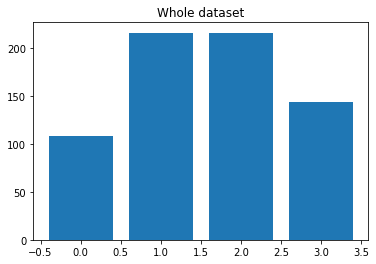

[0 1 2 3] [ 99 196 190 130]


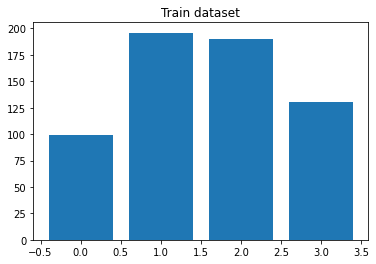

[0.35871954 0.18118997 0.18691176 0.27317873]
[0 1 2 3] [ 9 20 26 14]


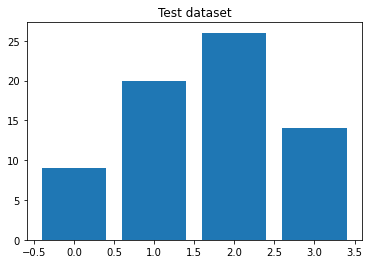

In [26]:
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Analyze class distribution and 
_classes, counts = np.unique(labels, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Whole dataset")
plt.show()

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                   test_size=0.1)

_classes, counts = np.unique(y_train, return_counts=True)
n_train_samples = len(y_train)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Train dataset")
plt.show()

# Compute the class weights used for training
CLASS_WEIGHTS = np.array([c / n_train_samples for c in counts])
CLASS_WEIGHTS = 1.0 / CLASS_WEIGHTS
CLASS_WEIGHTS = CLASS_WEIGHTS / CLASS_WEIGHTS.sum()
print(CLASS_WEIGHTS)

_classes, counts = np.unique(y_test, return_counts=True)
print(_classes, counts)
plt.bar(_classes, counts)
plt.title("Test dataset")
plt.show()

class AudioDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        assert len(self.x) == len(self.y)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx]), self.y[idx]
    
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,
                          num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True,
                          num_workers=0)

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from sklearn.metrics import classification_report
target_names = list(fi_dict.keys())
    
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=16,
                               kernel_size=(120, 40),
                               stride=4)
        
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=8,
                               kernel_size=(40, 1),
                               stride=2)
        
        self.dropout1 = nn.Dropout(p=0.25)
        self.dropout2 = nn.Dropout(p=0.25)
        
        self.linear1 = nn.Linear(8*154, 4)
        
    def forward(self, x):
        o1 = F.relu(self.conv1(x))
        o1 = self.dropout1(o1)
        #print(o1.shape)
        o2 = F.relu(self.conv2(o1))
        o2 = self.dropout2(o2)
        #print(o2.shape)
        
        out = self.linear1(o2.view(-1, 8*154))
        
        return out

INTERVAL = 35
    
model = ConvNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.00025, momentum=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(CLASS_WEIGHTS).cuda())

for epoch in range(500):
    print(f"Epoch {epoch+1}")
    running_loss = 0.0
    model.train()
    for i_batch, batch in enumerate(train_loader):
        x, y = batch[0].cuda(), batch[1].cuda()
        x = x.unsqueeze(1) # For conv net

        optimizer.zero_grad()
        
        pred_y = model(x)
        
        loss = criterion(pred_y, y)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if i_batch % INTERVAL == INTERVAL-1:
            running_loss += running_loss
            print(f"[{epoch+1}, {i_batch+1}]: Loss: {running_loss/INTERVAL:.4f}")
            
    if epoch % 10 == 9:
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            model.eval()
            for batch in test_loader:
                x, y = batch[0].cuda(), batch[1].cuda()
                x = x.unsqueeze(1)
                
                y_true += list(y.cpu().numpy())
                
                pred_y = model(x)
                _, predicted = torch.max(pred_y.data, 1)
                y_pred += list(predicted.cpu().numpy())
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        print(len(y_true), len(y_pred))
        print(y_true[0])
        print(classification_report(y_true, y_pred, target_names=target_names))
                
        acc = 100 * correct / total
        print(f"Test Acc: {acc:.3f}%")

Epoch 1
[1, 35]: Loss: 2.7906
Epoch 2
[2, 35]: Loss: 2.7581
Epoch 3
[3, 35]: Loss: 2.7177
Epoch 4
[4, 35]: Loss: 2.6395
Epoch 5
[5, 35]: Loss: 2.5172
Epoch 6
[6, 35]: Loss: 2.3929
Epoch 7
[7, 35]: Loss: 2.2744
Epoch 8
[8, 35]: Loss: 2.1568
Epoch 9
[9, 35]: Loss: 1.9853
Epoch 10
[10, 35]: Loss: 1.8235
69 69
2
              precision    recall  f1-score   support

     nothing       1.00      0.78      0.88         9
       pasta       0.50      0.85      0.63        20
        rice       0.69      0.35      0.46        26
       water       0.87      0.93      0.90        14

    accuracy                           0.67        69
   macro avg       0.76      0.73      0.72        69
weighted avg       0.71      0.67      0.65        69

Test Acc: 66.667%
Epoch 11
[11, 35]: Loss: 1.6903
Epoch 12
[12, 35]: Loss: 1.5719
Epoch 13
[13, 35]: Loss: 1.4688
Epoch 14
[14, 35]: Loss: 1.3373
Epoch 15
[15, 35]: Loss: 1.2191
Epoch 16
[16, 35]: Loss: 1.1032
Epoch 17
[17, 35]: Loss: 1.0529
Epoch 18
[18,

[111, 35]: Loss: 0.0219
Epoch 112
[112, 35]: Loss: 0.0246
Epoch 113
[113, 35]: Loss: 0.0348
Epoch 114
[114, 35]: Loss: 0.0182
Epoch 115
[115, 35]: Loss: 0.0332
Epoch 116
[116, 35]: Loss: 0.0453
Epoch 117
[117, 35]: Loss: 0.0269
Epoch 118
[118, 35]: Loss: 0.0261
Epoch 119
[119, 35]: Loss: 0.0226
Epoch 120
[120, 35]: Loss: 0.0219
69 69
3
              precision    recall  f1-score   support

     nothing       0.69      1.00      0.82         9
       pasta       0.95      0.95      0.95        20
        rice       0.96      0.88      0.92        26
       water       1.00      0.86      0.92        14

    accuracy                           0.91        69
   macro avg       0.90      0.92      0.90        69
weighted avg       0.93      0.91      0.92        69

Test Acc: 91.304%
Epoch 121
[121, 35]: Loss: 0.0215
Epoch 122
[122, 35]: Loss: 0.0454
Epoch 123
[123, 35]: Loss: 0.0226
Epoch 124
[124, 35]: Loss: 0.0242
Epoch 125
[125, 35]: Loss: 0.0232
Epoch 126
[126, 35]: Loss: 0.0283
Epoch

[217, 35]: Loss: 0.0078
Epoch 218
[218, 35]: Loss: 0.0082
Epoch 219
[219, 35]: Loss: 0.0071
Epoch 220
[220, 35]: Loss: 0.0085
69 69
2
              precision    recall  f1-score   support

     nothing       0.69      1.00      0.82         9
       pasta       0.95      0.95      0.95        20
        rice       0.96      0.88      0.92        26
       water       1.00      0.86      0.92        14

    accuracy                           0.91        69
   macro avg       0.90      0.92      0.90        69
weighted avg       0.93      0.91      0.92        69

Test Acc: 91.304%
Epoch 221
[221, 35]: Loss: 0.0047
Epoch 222
[222, 35]: Loss: 0.0070
Epoch 223
[223, 35]: Loss: 0.0098
Epoch 224
[224, 35]: Loss: 0.0096
Epoch 225
[225, 35]: Loss: 0.0062
Epoch 226
[226, 35]: Loss: 0.0070
Epoch 227
[227, 35]: Loss: 0.0093
Epoch 228
[228, 35]: Loss: 0.0108
Epoch 229
[229, 35]: Loss: 0.0098
Epoch 230
[230, 35]: Loss: 0.0107
69 69
1
              precision    recall  f1-score   support

     nothi

[321, 35]: Loss: 0.0056
Epoch 322
[322, 35]: Loss: 0.0062
Epoch 323
[323, 35]: Loss: 0.0055
Epoch 324
[324, 35]: Loss: 0.0039
Epoch 325
[325, 35]: Loss: 0.0030
Epoch 326
[326, 35]: Loss: 0.0046
Epoch 327
[327, 35]: Loss: 0.0053
Epoch 328
[328, 35]: Loss: 0.0033
Epoch 329
[329, 35]: Loss: 0.0058
Epoch 330
[330, 35]: Loss: 0.0038
69 69
0
              precision    recall  f1-score   support

     nothing       0.69      1.00      0.82         9
       pasta       0.95      0.95      0.95        20
        rice       0.96      0.88      0.92        26
       water       1.00      0.86      0.92        14

    accuracy                           0.91        69
   macro avg       0.90      0.92      0.90        69
weighted avg       0.93      0.91      0.92        69

Test Acc: 91.304%
Epoch 331
[331, 35]: Loss: 0.0061
Epoch 332
[332, 35]: Loss: 0.0062
Epoch 333
[333, 35]: Loss: 0.0031
Epoch 334
[334, 35]: Loss: 0.0028
Epoch 335
[335, 35]: Loss: 0.0051
Epoch 336
[336, 35]: Loss: 0.0023
Epoch

[427, 35]: Loss: 0.0069
Epoch 428
[428, 35]: Loss: 0.0016
Epoch 429
[429, 35]: Loss: 0.0019
Epoch 430
[430, 35]: Loss: 0.0021
69 69
3
              precision    recall  f1-score   support

     nothing       0.64      1.00      0.78         9
       pasta       0.95      0.90      0.92        20
        rice       0.96      0.88      0.92        26
       water       1.00      0.86      0.92        14

    accuracy                           0.90        69
   macro avg       0.89      0.91      0.89        69
weighted avg       0.92      0.90      0.90        69

Test Acc: 89.855%
Epoch 431
[431, 35]: Loss: 0.0021
Epoch 432
[432, 35]: Loss: 0.0020
Epoch 433
[433, 35]: Loss: 0.0018
Epoch 434
[434, 35]: Loss: 0.0058
Epoch 435
[435, 35]: Loss: 0.0024
Epoch 436
[436, 35]: Loss: 0.0014
Epoch 437
[437, 35]: Loss: 0.0124
Epoch 438
[438, 35]: Loss: 0.0022
Epoch 439
[439, 35]: Loss: 0.0018
Epoch 440
[440, 35]: Loss: 0.0023
69 69
3
              precision    recall  f1-score   support

     nothi

In [42]:
path = 'Dataset/10/audio/0012_audio.wav'
wavPlayer(path)

#fi_dict = {'nothing': 0, 'pasta': 1, 'rice': 2, 'water': 3}
rev = {0: 'nothing', 1: 'pasta', 2: 'rice', 3: 'water'}

def getModelPrediction(model, path):
    # Loading audio file and extracting MFCC feature
    features = load_and_extract_mfcc(path)
    
    # Padding the sequence
    pad_length = SEQUENCE_LENGTH - features.shape[0]
    features = np.concatenate([features, np.zeros((pad_length, N_MFCC))])

    feat_tensor = torch.Tensor(features)
    feat_tensor = feat_tensor.unsqueeze(0)
    feat_tensor = feat_tensor.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        out = model(feat_tensor.cuda())
        scores = F.softmax(out, dim=1).cpu().numpy()

        _class = np.argmax(scores)
        score = np.max(scores)

        print(f"`{rev[_class]}` with {score*100}% confidence")

        print(np.round(scores, 2))
        
    return _class
getModelPrediction(model,path)

`pasta` with 99.9754250049591% confidence
[[0. 1. 0. 0.]]


1

In [29]:
import pandas as pd
from natsort import natsorted 
prediction_list = []
for i in range(10,13,1):
    path = './Dataset/'+str(i)+'/audio/*'
    test_list = natsorted(glob.glob(path))
    for tl in test_list:
        print(tl)
    print("#############")
    #print(test_list)
    for i in range(0,len(test_list),1):
        prediction_list.append(getModelPrediction(model,test_list[i]))
print(len(prediction_list))        
print(prediction_list)

./Dataset/10/audio/0000_audio.wav
./Dataset/10/audio/0001_audio.wav
./Dataset/10/audio/0002_audio.wav
./Dataset/10/audio/0003_audio.wav
./Dataset/10/audio/0004_audio.wav
./Dataset/10/audio/0005_audio.wav
./Dataset/10/audio/0006_audio.wav
./Dataset/10/audio/0007_audio.wav
./Dataset/10/audio/0008_audio.wav
./Dataset/10/audio/0009_audio.wav
./Dataset/10/audio/0010_audio.wav
./Dataset/10/audio/0011_audio.wav
./Dataset/10/audio/0012_audio.wav
./Dataset/10/audio/0013_audio.wav
./Dataset/10/audio/0014_audio.wav
./Dataset/10/audio/0015_audio.wav
./Dataset/10/audio/0016_audio.wav
./Dataset/10/audio/0017_audio.wav
./Dataset/10/audio/0018_audio.wav
./Dataset/10/audio/0019_audio.wav
./Dataset/10/audio/0020_audio.wav
./Dataset/10/audio/0021_audio.wav
./Dataset/10/audio/0022_audio.wav
./Dataset/10/audio/0023_audio.wav
./Dataset/10/audio/0024_audio.wav
./Dataset/10/audio/0025_audio.wav
./Dataset/10/audio/0026_audio.wav
./Dataset/10/audio/0027_audio.wav
./Dataset/10/audio/0028_audio.wav
./Dataset/10/a

`rice` with 100.0% confidence
[[0. 0. 1. 0.]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`water` with 99.99868869781494% confidence
[[0. 0. 0. 1.]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`rice` with 99.99990463256836% confidence
[[0. 0. 1. 0.]]
`rice` with 99.95043277740479% confidence
[[0. 0. 1. 0.]]
`nothing` with 99.99758005142212% confidence
[[1. 0. 0. 0.]]
`water` with 100.0% confidence
[[0. 0. 0. 1.]]
`rice` with 99.99998807907104% confidence
[[0. 0. 1. 0.]]
`pasta` with 84.4216525554657% confidence
[[0.16 0.84 0.   0.  ]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`rice` with 99.9993085861206% confidence
[[0. 0. 1. 0.]]
`nothing` with 98.73746037483215% confidence
[[0.99 0.   0.   0.01]]
`water` with 69.6721613407135% confidence
[[0.29 0.01 0.   0.7 ]]
`rice` with 58.58129858970642% confidence
[[0.   0.41 0.59 0.  ]]
`rice` with 95.43747901916504% confidence
[[0.   0.05 0.95 0.  ]]
`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`water` with 99.9940037727356% conf

`pasta` with 100.0% confidence
[[0. 1. 0. 0.]]
`pasta` with 99.99995231628418% confidence
[[0. 1. 0. 0.]]
`nothing` with 99.99574422836304% confidence
[[1. 0. 0. 0.]]
`pasta` with 99.9990701675415% confidence
[[0. 1. 0. 0.]]
`pasta` with 95.80512642860413% confidence
[[0.   0.96 0.04 0.  ]]
`nothing` with 87.62450218200684% confidence
[[0.88 0.01 0.11 0.  ]]
`pasta` with 99.78544116020203% confidence
[[0. 1. 0. 0.]]
`nothing` with 99.99876022338867% confidence
[[1. 0. 0. 0.]]
`pasta` with 99.99961853027344% confidence
[[0. 1. 0. 0.]]
`rice` with 99.92291927337646% confidence
[[0. 0. 1. 0.]]
`pasta` with 84.88975763320923% confidence
[[0.   0.85 0.15 0.  ]]
`rice` with 99.98819828033447% confidence
[[0. 0. 1. 0.]]
`pasta` with 99.99666213989258% confidence
[[0. 1. 0. 0.]]
`rice` with 85.91668009757996% confidence
[[0.   0.14 0.86 0.  ]]
`nothing` with 99.98041987419128% confidence
[[1. 0. 0. 0.]]
`pasta` with 98.27314019203186% confidence
[[0.   0.98 0.02 0.  ]]
`rice` with 99.947863817

In [8]:
def generatesubmission(feature,data_list):
    df = pd.read_csv('submissions/submissionfile.csv',index_col=0)
    df[feature] = data_list
    df.to_csv('./submissions/submissionfile-record.csv')

In [9]:
generatesubmission('Filling type',prediction_list)